In [1]:
import numpy as np
import matplotlib.pyplot as ppt
%matplotlib inline
import PIL.Image as pilimage
import caffe
import adex
import adex.core
import adex.googlenet

CAFFE_ROOT = '/home/chrisbot/Projects/caffe'

# Original image info
IMAGE_PATH = '/media/sf_Masterarbeit/data/example_images/panda.jpg'
SAVE_PATH_PREFIX = '/media/sf_Masterarbeit/master-thesis/report/panda'

#IMAGE_PATH = '/media/sf_Masterarbeit/data/ILSVRC2012_img_train/n02676566/n02676566_777.JPEG' # guitar
#SAVE_PATH_PREFIX = '/media/sf_Masterarbeit/master-thesis/report/n02676566_777_guitar'

# Target class info
TARGET_CLASS_NAME = ('n12267677', 'acorn')
#TARGET_CLASS_NAME = ('n03016953', 'dresser')
#TARGET_CLASS_NAME = ('n03837869', 'obelisk')
#TARGET_CLASS_NAME = 'n02749479' #rifle
#TARGET_CLASS_NAME = ('n03781244', 'monastery')
#TARGET_CLASS_NAME = ('n02966687', 'toolbox')
#TARGET_CLASS_NAME = ('n02782093', 'hot air-baloon')

NORM_PERCENTILE = 98
BATCH_SIZE = 1

AE_GRAD_COEFF = 0.477
ITERATIONS = 53

In [2]:
net = adex.googlenet.load_model(CAFFE_ROOT, BATCH_SIZE)
labels = adex.googlenet.load_labels(CAFFE_ROOT)
transformer = adex.googlenet.build_transformer(net)

image = caffe.io.load_image(IMAGE_PATH)
image = transformer.preprocess('data', image)
image = np.expand_dims(image, 0)

target_label = adex.googlenet.get_label_from_class_name(labels, TARGET_CLASS_NAME[0])
target_label = np.array([target_label]) # Caffe-friendly format for labels
print(labels[target_label[0]])

['n12267677 ', 'acorn']


In [3]:
adversarial_image, confidence, iterations = adex.core.make_adversarial(net, image, target_label, AE_GRAD_COEFF,
                                                                               1.1, ITERATIONS)
#adversarial_image = image # FIXME

['n02510455 ', 'giant panda', ' panda', ' panda bear', ' coon bear', ' Ailuropoda melanoleuca']: 10.64% certainty
0.106408
['n04399382 ', 'teddy', ' teddy bear']: 9.29% certainty
0.0928675
['n02342885 ', 'hamster']: 4.33% certainty
0.043344
['n12267677 ', 'acorn']: 3.71% certainty
0.0371297
['n07760859 ', 'custard apple']: 3.64% certainty
0.0363888
['n02364673 ', 'guinea pig', ' Cavia cobaya']: 3.27% certainty
0.0327134


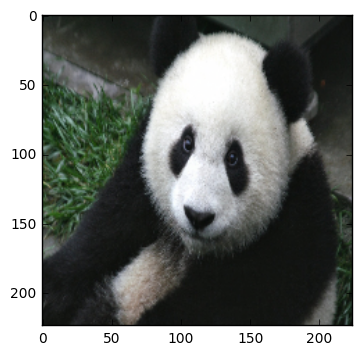

In [9]:
predictions, probabilities = adex.core.predict(net, adversarial_image)
predictions, probabilities = predictions[0], probabilities[0]
ae_image_deprocessed = transformer.deprocess('data', adversarial_image)
ppt.imshow(ae_image_deprocessed)
for ind, p in enumerate(predictions):
    if ind > 5:
        break
    label = labels[p]
    probability = probabilities[p]
    print( '{0}: {1}% certainty'.format(label, round(probability*100, 2)) )
    print(probability)

In [5]:
def save_img(img, path):
    img = transformer.deprocess('data', img)
    img *= 255
    img = img.astype(np.uint8)
    
    pil_img = pilimage.fromarray(img, 'RGB')
    pil_img.save(path)

#save_img(image, SAVE_PATH)
#save_img(adversarial_image, AE_SAVE_PATH)
save_img(image, SAVE_PATH_PREFIX + '.png')
save_img(adversarial_image, SAVE_PATH_PREFIX + '_{0}_{1}_{2:.1f}.png'.format(TARGET_CLASS_NAME[1], ITERATIONS, AE_GRAD_COEFF))

In [6]:
diff = image - adversarial_image
diff /= np.percentile(diff, NORM_PERCENTILE)

diff_deproc = transformer.deprocess('data', diff)
#ppt.imshow(diff_deproc)
#save_img(diff, DIFF_SAVE_PATH)

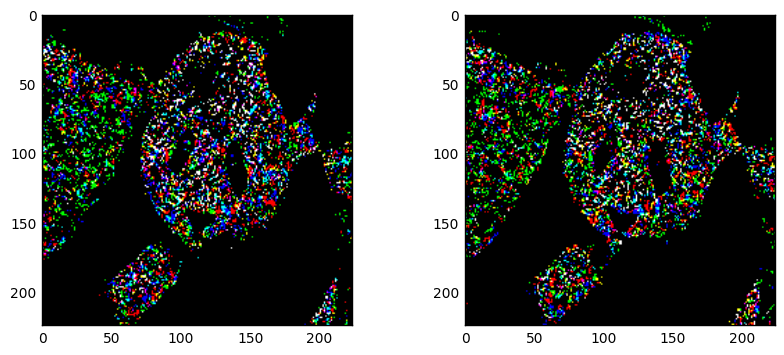

In [7]:
diff = 255.0 / AE_GRAD_COEFF * (adversarial_image - image) # 0..255
#diff = np.abs(diff) # Retain large negative values

pos_diff, neg_diff = diff.copy(), diff.copy()

pos_diff[pos_diff < 0] = 0
pos_diff[pos_diff < np.percentile(pos_diff, 99)] = 0

neg_diff *= -1
neg_diff[neg_diff < 0] = 0
neg_diff[neg_diff < np.percentile(neg_diff, 99)] = 0

ppt.figure(figsize=(10, 4))
ax = ppt.subplot(1, 2, 1)
ppt.imshow(transformer.deprocess('data', pos_diff))
ax = ppt.subplot(1, 2, 2)
ppt.imshow(transformer.deprocess('data', neg_diff))

save_img(pos_diff, SAVE_PATH_PREFIX + '_{0}_{1}_{2:.1f}_posdiff.png'.format(TARGET_CLASS_NAME[1], ITERATIONS, AE_GRAD_COEFF))
save_img(neg_diff, SAVE_PATH_PREFIX + '_{0}_{1}_{2:.1f}_negdiff.png'.format(TARGET_CLASS_NAME[1], ITERATIONS, AE_GRAD_COEFF))

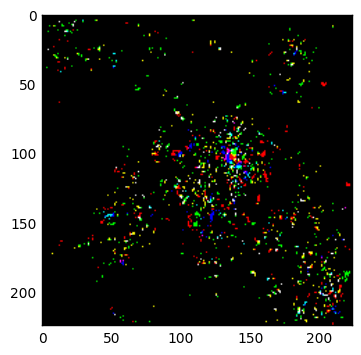

In [8]:
def predict(net, image):
    net.blobs['data'].data[...] = image
    probabilities = net.forward()['prob'][0]
    predictions = probabilities.argsort()[::-1]
    
    return predictions, probabilities

def compute_gradient(net, image, desired_label):
    _, _ = predict(net, image)
    probs = np.zeros_like(net.blobs['prob'].data)
    probs[0][desired_label] = 1
    
    gradient = net.backward(prob=probs, diffs=['data'])
    return gradient['data'].copy()

grad = compute_gradient(net, image, target_label)
grad /= np.percentile(grad, NORM_PERCENTILE)
#p = np.percentile(grad, NORM_PERCENTILE)
#grad[grad<p] = np.min(grad)
grad_deproc = transformer.deprocess('data', grad)
ppt.imshow(grad_deproc)

#save_img(grad, GRAD_SAVE_PATH)
save_img(grad, SAVE_PATH_PREFIX + '_{0}_{1}_{2:.1f}_grad.png'.format(TARGET_CLASS_NAME[1], ITERATIONS, AE_GRAD_COEFF))